In [13]:
N_JOBS = 55
import pandas as pd 
import os 
import pickle

In [23]:
dfs = []
root = './descriptors/'
for file in sorted(os.listdir(root)):
    if file.endswith('.pkl'):
        df = pd.read_pickle(root + file)
        dfs.append(df)

df = pd.concat(dfs, axis=0).reset_index(drop=True)

In [ ]:
family1 = ['coeff_cause', 'coeff_eff','n_samples',
       'n_features', 'n_features/n_samples', 'kurtosis_ca', 'kurtosis_ef',
       'skewness_ca', 'skewness_ef', 'HOC_1_2', 'HOC_2_1', 'HOC_1_3',
       'HOC_3_1']

family2 = ['cau_eff', 'eff_cau','m_cau_q0','m_cau_q1', 'm_cau_q2', 'm_cau_q3', 'm_cau_q4', 'm_cau_q5', 'm_cau_q6',
       'm_eff_q0', 'm_eff_q1', 'm_eff_q2', 'm_eff_q3', 'm_eff_q4', 'm_eff_q5',
       'm_eff_q6']

family3 = ['com_cau',
           'eff_cau_mbeff',
        'cau_eff_mbcau', 'eff_cau_mbcau_plus_q0', 'eff_cau_mbcau_plus_q1',
        'eff_cau_mbcau_plus_q2', 'eff_cau_mbcau_plus_q3',
        'eff_cau_mbcau_plus_q4', 'eff_cau_mbcau_plus_q5',
        'eff_cau_mbcau_plus_q6', 'cau_eff_mbeff_plus_q0',
        'cau_eff_mbeff_plus_q1', 'cau_eff_mbeff_plus_q2',
        'cau_eff_mbeff_plus_q3', 'cau_eff_mbeff_plus_q4',
        'cau_eff_mbeff_plus_q5', 'cau_eff_mbeff_plus_q6']


family4 = ['cau_m_eff_q0', 'cau_m_eff_q1', 'cau_m_eff_q2',
       'cau_m_eff_q3', 'cau_m_eff_q4', 'cau_m_eff_q5', 'cau_m_eff_q6',
       'eff_m_cau_q0', 'eff_m_cau_q1', 'eff_m_cau_q2', 'eff_m_cau_q3',
       'eff_m_cau_q4', 'eff_m_cau_q5', 'eff_m_cau_q6', 'mca_mef_cau_q0',
       'mca_mef_cau_q1', 'mca_mef_cau_q2', 'mca_mef_cau_q3', 'mca_mef_cau_q4',
       'mca_mef_cau_q5', 'mca_mef_cau_q6', 'mca_mef_eff_q0', 'mca_mef_eff_q1',
       'mca_mef_eff_q2', 'mca_mef_eff_q3', 'mca_mef_eff_q4', 'mca_mef_eff_q5',
       'mca_mef_eff_q6']

family5 = ['mca_mca_cau_q0', 'mca_mca_cau_q1', 'mca_mca_cau_q2',
       'mca_mca_cau_q3', 'mca_mca_cau_q4', 'mca_mca_cau_q5', 'mca_mca_cau_q6',
       'mbe_mbe_eff_q0', 'mbe_mbe_eff_q1', 'mbe_mbe_eff_q2', 'mbe_mbe_eff_q3',
       'mbe_mbe_eff_q4', 'mbe_mbe_eff_q5', 'mbe_mbe_eff_q6']

In [ ]:
families = [family1, family2, family3, family4, family5]

In [ ]:
X_full = df[df.columns[8:]]
y_full = df['is_causal']

X_train = X_full.loc[df.process_id % 2 == 0]
y_train = y_full.loc[df.process_id % 2 == 0]
X_test = X_full.loc[df.process_id % 2 == 1]
y_test = y_full.loc[df.process_id % 2 == 1]

In [ ]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
from sklearn.metrics import roc_auc_score, roc_curve

scores_per_family_excluded = {}
for family_idx, family in tqdm(enumerate(families)):
    columns_without_family = [col for col in X_full.columns if col not in family]
    X_train_family, X_test_family = X_train[columns_without_family], X_test[columns_without_family]
    
    rf = RandomForestClassifier(n_estimators=N_JOBS, random_state=42, n_jobs=N_JOBS)
    rf.fit(X_train_family, y_train)
    y_hat_rf = rf.predict_proba(X_test_family)[:,-1]
    roc_auc_score_rf = roc_auc_score(y_test, y_hat_rf)
    roc_curve_rf = roc_curve(y_test, y_hat_rf)
    scores_per_family_excluded[family_idx] = roc_auc_score_rf, roc_curve_rf
    

5it [01:12, 14.48s/it]


In [ ]:
for key, value in scores_per_family_excluded.items():
    roc_auc_score_rf, roc_curve_rf = value
    print('Excluding family', key)
    print('ROC AUC:', roc_auc_score_rf)

Excluding family 0
ROC AUC: 0.8081603374632952
Excluding family 1
ROC AUC: 0.8167598866822461
Excluding family 2
ROC AUC: 0.8223943648726852
Excluding family 3
ROC AUC: 0.8070471395526566
Excluding family 4
ROC AUC: 0.8178817617910881


In [ ]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
from sklearn.metrics import roc_auc_score, roc_curve

scores_per_family_included = {}
for family_idx, family in tqdm(enumerate(families)):
    X_train_family, X_test_family = X_train[family], X_test[family]
    
    rf = RandomForestClassifier(n_estimators=N_JOBS, random_state=42, n_jobs=N_JOBS)
    rf.fit(X_train_family, y_train)
    y_hat_rf = rf.predict_proba(X_test_family)[:,-1]
    roc_auc_score_rf = roc_auc_score(y_test, y_hat_rf)
    roc_curve_rf = roc_curve(y_test, y_hat_rf)
    scores_per_family_included[family_idx] = roc_auc_score_rf, roc_curve_rf
    

5it [00:40,  8.13s/it]


In [ ]:
for key, value in scores_per_family_included.items():
    roc_auc_score_rf, roc_curve_rf = value
    print('Using only family', key)
    print('ROC AUC:', roc_auc_score_rf)

Using only family 0
ROC AUC: 0.7755086392291454
Using only family 1
ROC AUC: 0.7214882737315405
Using only family 2
ROC AUC: 0.7329585693610547
Using only family 3
ROC AUC: 0.794878012197989
Using only family 4
ROC AUC: 0.7392053201139055


In [ ]:
roc_auc_score_rf_all

0.8219223091617369

In [ ]:
rfe = ['coeff_cause', 'coeff_eff', 'cau_eff', 'eff_cau', 'm_cau_q5', 'm_cau_q6', 'm_eff_q6', 'cau_m_eff_q5', 'cau_m_eff_q6', 'eff_m_cau_q5', 'eff_m_cau_q6', 'mca_mef_cau_q4', 'mca_mef_cau_q5', 'mca_mef_cau_q6', 'mca_mef_eff_q4', 'mca_mef_eff_q5', 'mca_mef_eff_q6', 'mca_mca_cau_q5', 'mca_mca_cau_q6', 'mbe_mbe_eff_q0', 'mbe_mbe_eff_q6', 'kurtosis_ca', 'kurtosis_ef', 'skewness_ca', 'skewness_ef', 'HOC_1_2', 'HOC_2_1', 'HOC_1_3', 'HOC_3_1']

fw = ['coeff_cause', 'coeff_eff', 'm_cau_q6', 'mca_mef_cau_q4',
        'mca_mef_eff_q4', 'mca_mca_cau_q2', 'mbe_mbe_eff_q0', 'kurtosis_ca',
        'kurtosis_ef', 'HOC_2_1', 'HOC_3_1']


bw = ['com_cau', 'coeff_cause', 'coeff_eff', 'cau_eff', 'eff_cau',
        'eff_cau_mbeff', 'cau_eff_mbcau', 'eff_cau_mbcau_plus_q1',
        'eff_cau_mbcau_plus_q2', 'eff_cau_mbcau_plus_q3',
        'eff_cau_mbcau_plus_q4', 'eff_cau_mbcau_plus_q5',
        'eff_cau_mbcau_plus_q6', 'cau_eff_mbeff_plus_q0',
        'cau_eff_mbeff_plus_q1', 'cau_eff_mbeff_plus_q5',
        'cau_eff_mbeff_plus_q6', 'm_cau_q0', 'm_cau_q1', 'm_cau_q2', 'm_cau_q5',
        'm_cau_q6', 'm_eff_q0', 'm_eff_q2', 'm_eff_q3', 'm_eff_q4',
        'cau_m_eff_q1', 'cau_m_eff_q2', 'cau_m_eff_q4', 'cau_m_eff_q5',
        'cau_m_eff_q6', 'eff_m_cau_q3', 'eff_m_cau_q4', 'eff_m_cau_q6',
        'mca_mef_cau_q0', 'mca_mef_cau_q1', 'mca_mef_cau_q2', 'mca_mef_cau_q3',
        'mca_mef_cau_q4', 'mca_mef_cau_q5', 'mca_mef_eff_q0', 'mca_mef_eff_q1',
        'mca_mef_eff_q2', 'mca_mef_eff_q3', 'mca_mef_eff_q4', 'mca_mef_eff_q5',
        'mca_mef_eff_q6', 'mca_mca_cau_q0', 'mca_mca_cau_q1', 'mca_mca_cau_q2',
        'mca_mca_cau_q3', 'mca_mca_cau_q4', 'mca_mca_cau_q5', 'mca_mca_cau_q6',
       'mbe_mbe_eff_q1', 'mbe_mbe_eff_q2', 'mbe_mbe_eff_q5', 'n_samples',
        'n_features', 'n_features/n_samples', 'kurtosis_ca', 'kurtosis_ef',
        'skewness_ca', 'HOC_1_2', 'HOC_1_3', 'HOC_3_1']


In [ ]:
# intersection of the 3
rfe_fw_bw = list(set(rfe) & set(fw) & set(bw))
rfe_fw_bw

['m_cau_q6',
 'mca_mef_eff_q4',
 'kurtosis_ca',
 'HOC_3_1',
 'coeff_cause',
 'coeff_eff',
 'kurtosis_ef',
 'mca_mef_cau_q4']

In [ ]:
#Feature Selection


from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
from sklearn.metrics import roc_auc_score, roc_curve

scores_per_FS = {}
for fs_idx, fs in tqdm(enumerate([fw, bw, rfe, rfe_fw_bw ])):
    X_train_family, X_test_family = X_train[fs], X_test[fs]
    
    rf = RandomForestClassifier(n_estimators=N_JOBS, random_state=42, n_jobs=N_JOBS)
    rf.fit(X_train_family, y_train)
    y_hat_rf = rf.predict_proba(X_test_family)[:,-1]
    roc_auc_score_rf = roc_auc_score(y_test, y_hat_rf)
    roc_curve_rf = roc_curve(y_test, y_hat_rf)
    scores_per_FS[fs_idx] = roc_auc_score_rf, roc_curve_rf
    

6it [01:35, 15.94s/it]


In [ ]:
for key, value in scores_per_FS.items():
    roc_auc_score_rf, roc_curve_rf = value
    print('Using FS', key)
    print('ROC AUC:', roc_auc_score_rf)

Using FS 0
ROC AUC: 0.8150725636339645
Using FS 1
ROC AUC: 0.8206836066017098
Using FS 2
ROC AUC: 0.805132315184877
Using FS 3
ROC AUC: 0.8086460872446068
Using FS 4
ROC AUC: 0.7826462938347962
Using FS 5
ROC AUC: 0.7371872908310962


In [ ]:
refined = ['mca_mef_eff_q4',
 'mca_mef_cau_q4',
 'coeff_cause',
 'coeff_eff']
refined_further = ['mca_mef_eff_q4',
 'mca_mef_cau_q4',
 ]

refined_further_2 =[
 'kurtosis_ef',
 'HOC_3_1',
 'kurtosis_ca']

In [ ]:
#Feature Selection


from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
from sklearn.metrics import roc_auc_score, roc_curve

scores_per_FS = {}
for fs_idx, fs in tqdm(enumerate([refined_further_2])):
    X_train_family, X_test_family = X_train[fs], X_test[fs]
    
    rf = RandomForestClassifier(n_estimators=N_JOBS, random_state=42, n_jobs=N_JOBS)
    rf.fit(X_train_family, y_train)
    y_hat_rf = rf.predict_proba(X_test_family)[:,-1]
    roc_auc_score_rf = roc_auc_score(y_test, y_hat_rf)
    roc_curve_rf = roc_curve(y_test, y_hat_rf)
    scores_per_FS[fs_idx] = roc_auc_score_rf, roc_curve_rf
    

1it [00:10, 10.74s/it]


In [ ]:
for key, value in scores_per_FS.items():
    roc_auc_score_rf, roc_curve_rf = value
    print('Using FS', key)
    print('ROC AUC:', roc_auc_score_rf)

Using FS 0
ROC AUC: 0.754388135586125


In [ ]:
df.graph_id

,process_id,graph_id,n_variables,max_neighborhood_size,noise_std,edge_source,edge_dest,is_causal,com_cau,coeff_cause,...,n_features,n_features/n_samples,kurtosis_ca,kurtosis_ef,skewness_ca,skewness_ef,HOC_1_2,HOC_2_1,HOC_1_3,HOC_3_1
0,10,0,10,2,0.001,53,43,1,0.000000,-0.055839,...,60,0.244898,-0.357741,-0.334877,0.121920,0.134386,0.005074,-0.157258,-0.209406,-0.162588
1,10,0,10,2,0.001,43,53,0,0.000000,-0.076287,...,60,0.244898,-0.334877,-0.357741,0.134386,0.121920,-0.157258,0.005074,-0.162588,-0.209406
2,10,0,10,2,0.001,12,2,1,0.000000,-0.031321,...,60,0.244898,0.032080,0.026375,-0.025887,-0.021662,0.094016,0.023107,-0.355195,-0.287429
3,10,0,10,2,0.001,2,12,0,0.000000,-0.038410,...,60,0.244898,0.026375,0.032080,-0.021662,-0.025887,0.023107,0.094016,-0.287429,-0.355195
4,10,0,10,2,0.001,56,46,1,0.000000,0.000595,...,60,0.244898,239.973886,-0.236477,-15.555018,0.037425,0.009013,-0.925678,0.054564,14.460204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164983,9,39,5,8,0.010,20,1,0,0.476586,-0.001049,...,30,0.122449,-0.208012,-0.133645,0.228085,0.241703,0.211850,0.024332,1.798662,1.645047
1164984,9,39,5,8,0.010,24,0,0,0.480128,0.006251,...,30,0.122449,-0.158592,-0.204863,0.231562,0.222791,0.188314,0.011622,1.791629,1.673121
1164985,9,39,5,8,0.010,16,2,0,0.000000,-0.015526,...,30,0.122449,-0.140688,-0.109951,0.247595,0.235655,0.617395,-0.635792,-0.395584,-0.779782
1164986,9,39,5,8,0.010,16,3,0,0.000000,-0.003245,...,30,0.122449,-0.140688,-0.133437,0.247595,0.233724,0.615256,-0.623462,-0.337067,-0.704838


In [22]:
df.process_id.unique()

array([9])

In [33]:
# How many training dags do we need? 

from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
from sklearn.metrics import roc_auc_score, roc_curve

X_full = df[df.columns[8:]]
y_full = df['is_causal']

roc_auc_score_rf_per_max_graph = {}
for max_graph in range(1,40):
    X_train = X_full.loc[df.process_id % 2 == 0].loc[df.graph_id <= max_graph]
    y_train = y_full.loc[df.process_id % 2 == 0].loc[df.graph_id <= max_graph]
    X_test = X_full.loc[df.process_id % 2 == 1]
    y_test = y_full.loc[df.process_id % 2 == 1]

    X_train = X_train[rfe_fw_bw]
    X_test = X_test[rfe_fw_bw]


    rf = RandomForestClassifier(n_estimators=N_JOBS, random_state=42, n_jobs=N_JOBS)
    rf.fit(X_train, y_train)
    y_hat_rf = rf.predict_proba(X_test)[:,-1]
    roc_auc_score_rf = roc_auc_score(y_test, y_hat_rf)
    roc_curve_rf = roc_curve(y_test, y_hat_rf)
    roc_auc_score_rf_per_max_graph[max_graph] = roc_auc_score_rf, roc_curve_rf
    

In [34]:
for key, value in roc_auc_score_rf_per_max_graph.items():
    roc_auc_score_rf, roc_curve_rf = value
    print('MAX GRAPH', key)
    print('ROC AUC:', roc_auc_score_rf)

MAX GRAPH 1
ROC AUC: 0.6935261257511762
MAX GRAPH 2
ROC AUC: 0.699543166373296
MAX GRAPH 3
ROC AUC: 0.7157661899980039
MAX GRAPH 4
ROC AUC: 0.7210662973746678
MAX GRAPH 5
ROC AUC: 0.7192961442442425
MAX GRAPH 6
ROC AUC: 0.7215172094776797
MAX GRAPH 7
ROC AUC: 0.7272708425514001
MAX GRAPH 8
ROC AUC: 0.7286022402414079
MAX GRAPH 9
ROC AUC: 0.734267756558642
MAX GRAPH 10
ROC AUC: 0.7358970888156131
MAX GRAPH 11
ROC AUC: 0.7308612479420519
MAX GRAPH 12
ROC AUC: 0.7375688720200778
MAX GRAPH 13
ROC AUC: 0.7395356484076941
MAX GRAPH 14
ROC AUC: 0.7475798769936477
MAX GRAPH 15
ROC AUC: 0.7504320064675498
MAX GRAPH 16
ROC AUC: 0.7528749672720954
MAX GRAPH 17
ROC AUC: 0.7592304628139334
MAX GRAPH 18
ROC AUC: 0.762588101979113
MAX GRAPH 19
ROC AUC: 0.7672336963125055
MAX GRAPH 20
ROC AUC: 0.7680058466237595
MAX GRAPH 21
ROC AUC: 0.7695523790817365
MAX GRAPH 22
ROC AUC: 0.7706332571356712
MAX GRAPH 23
ROC AUC: 0.7743430243095742
MAX GRAPH 24
ROC AUC: 0.7823661602004565
MAX GRAPH 25
ROC AUC: 0.7783

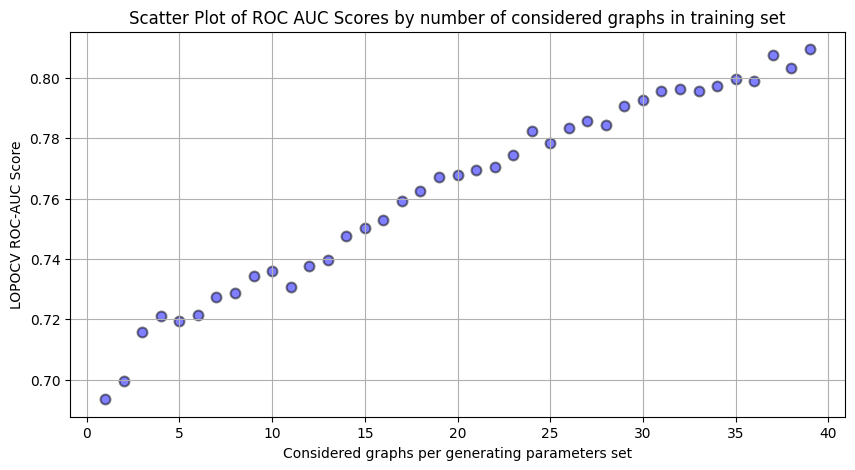

In [42]:
import matplotlib.pyplot as plt


# Preparing data for plotting
max_graph_sizes = list(roc_auc_score_rf_per_max_graph.keys())
roc_auc_scores = [value[0] for value in roc_auc_score_rf_per_max_graph.values()]

# Creating the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(max_graph_sizes, roc_auc_scores, color='blue',marker='o', s=50, alpha=0.5, edgecolors='black', linewidth=1.5, label='ROC AUC Scores')
plt.title('Scatter Plot of ROC AUC Scores by number of considered graphs in training set')
plt.xlabel('Considered graphs per generating parameters set')
plt.ylabel('LOPOCV ROC-AUC Score')
plt.grid(True)
plt.show()


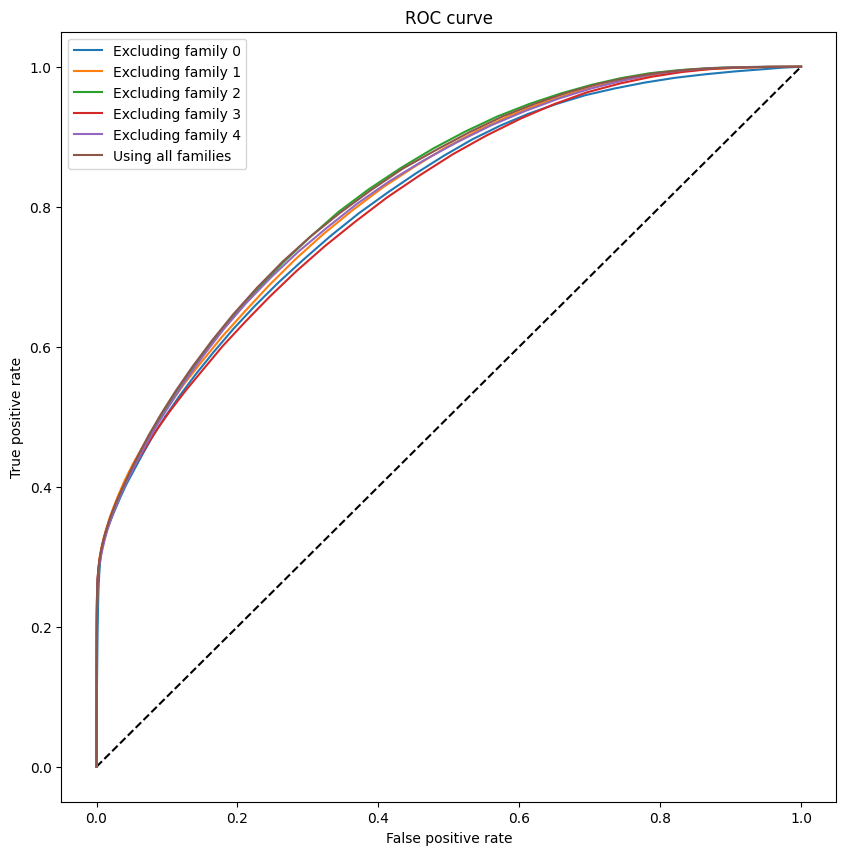

In [ ]:
# plot roc curves
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
for key, value in scores_per_family_excluded.items():
    roc_auc_score_rf, roc_curve_rf = value
    fpr, tpr, _ = roc_curve_rf
    plt.plot(fpr, tpr, label='Excluding family {}'.format(key))
# for key, value in scores_per_family_included.items():
#     roc_auc_score_rf, roc_curve_rf = value
#     fpr, tpr, _ = roc_curve_rf
#     plt.plot(fpr, tpr, label='Using only family {}'.format(key))
fpr, tpr, _ = roc_curve_rf_all
plt.plot(fpr, tpr, label='Using all families')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


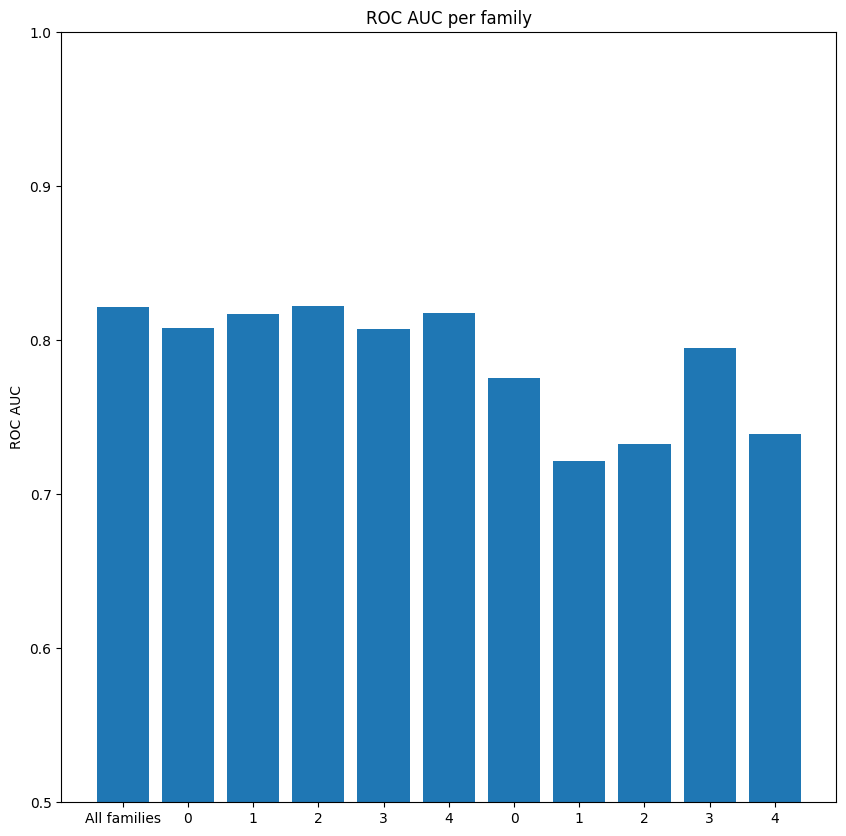

In [ ]:
#barplot roc auc 
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,10))
roc_auc_scores_excluded = [value[0] for value in scores_per_family_excluded.values()]
roc_auc_scores_included = [value[0] for value in scores_per_family_included.values()]
roc_auc_scores = [roc_auc_score_rf_all] + roc_auc_scores_excluded + roc_auc_scores_included
plt.bar(np.arange(len(roc_auc_scores)), roc_auc_scores)
plt.xticks(np.arange(len(roc_auc_scores)), ['All families'] + list(range(5)) + list(range(5)))
plt.ylabel('ROC AUC')
plt.title('ROC AUC per family')
#rescale to show from 0.5 to 1
plt.ylim(0.5, 1)
plt.show()


In [ ]:
#LOPO VERSION - very long 
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import LeaveOneGroupOut
# from tqdm import tqdm
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd 

# X_full = df[df.columns[8:]]
# y_full = df['is_causal']
# groups = df['process_id']

# logo = LeaveOneGroupOut()
# logo.get_n_splits(X_full, y_full, groups)

# roc_auc_per_family_excluded = {}
# for family_idx, family in tqdm(enumerate(families)):
#     df_scores = pd.DataFrame(columns=['roc_auc'])
#     columns = X_full.columns
#     columns_without_family = [col for col in columns if col not in family]
#     X = X_full[columns_without_family]
#     for train_index, test_index in tqdm(logo.split(X, y_full, groups)):
#         group = groups[test_index[0]]

#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

#         rf = RandomForestClassifier(n_estimators=N_JOBS*2, random_state=42, n_jobs=N_JOBS)
#         # brf = BalancedRandomForestClassifier(n_estimators=50, random_state=42, sampling_strategy='all',replacement=True,n_jobs=25)

#         rf.fit(X_train, y_train)
#         # brf.fit(X_train, y_train)

#         y_hat_rf = rf.predict_proba(X_test)[:,-1]
#         # y_hat_brf = brf.predict_proba(X_test)[:,-1]

#         score_rf = roc_auc_score(y_test, y_hat_rf)
#         # score_brf = roc_auc_score(y_test, y_hat_brf)

#         df_scores.loc[group] = [score_rf]
#     roc_auc_per_family_excluded[family_idx + 1] = df_scores

In [ ]:
#LOPO VERSION - very long 
X_full = df[df.columns[8:]]
y_full = df['is_causal']
groups = df['process_id']

logo = LeaveOneGroupOut()
logo.get_n_splits(X_full, y_full, groups)

df_scores = pd.DataFrame(columns=['roc_auc'])
columns = X_full.columns
X = X_full
for train_index, test_index in tqdm(logo.split(X, y_full, groups)):
    group = groups[test_index[0]]

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=N_JOBS*2, random_state=42, n_jobs=N_JOBS)
    # brf = BalancedRandomForestClassifier(n_estimators=50, random_state=42, sampling_strategy='all',replacement=True,n_jobs=25)

    rf.fit(X_train, y_train)
    # brf.fit(X_train, y_train)

    y_hat_rf = rf.predict_proba(X_test)[:,-1]
    # y_hat_brf = brf.predict_proba(X_test)[:,-1]

    score_rf = roc_auc_score(y_test, y_hat_rf)
    # score_brf = roc_auc_score(y_test, y_hat_brf)

    df_scores.loc[group] = [score_rf]

18it [19:20, 64.49s/it]


In [ ]:
full = df_scores

In [ ]:
#import roc auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneGroupOut
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 

X_full = df[df.columns[8:]]
y_full = df['is_causal']
groups = df['process_id']

logo = LeaveOneGroupOut()
logo.get_n_splits(X_full, y_full, groups)

roc_auc_per_family_included = {}
for family_idx, family in tqdm(enumerate(families)):
    df_scores = pd.DataFrame(columns=['roc_auc'])
    X = X_full[family]
    for train_index, test_index in tqdm(logo.split(X, y_full, groups)):
        group = groups[test_index[0]]

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

        rf = RandomForestClassifier(n_estimators=N_JOBS*2, random_state=42, n_jobs=N_JOBS)
        # brf = BalancedRandomForestClassifier(n_estimators=50, random_state=42, sampling_strategy='all',replacement=True,n_jobs=25)

        rf.fit(X_train, y_train)
        # brf.fit(X_train, y_train)

        y_hat_rf = rf.predict_proba(X_test)[:,-1]
        # y_hat_brf = brf.predict_proba(X_test)[:,-1]

        score_rf = roc_auc_score(y_test, y_hat_rf)
        # score_brf = roc_auc_score(y_test, y_hat_brf)

        df_scores.loc[group] = [score_rf]
    roc_auc_per_family_included[family_idx + 1] = df_scores

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:32, 32.42s/it]
2it [01:03, 31.88s/it]
3it [01:32, 31.21s/it]
4it [02:03, 31.24s/it]
5it [02:34, 31.01s/it]
6it [03:04, 30.84s/it]
7it [03:34, 30.53s/it]
8it [04:04, 30.30s/it]
9it [04:33, 29.94s/it]
10it [05:02, 29.77s/it]
11it [05:33, 30.04s/it]
12it [06:03, 30.01s/it]
13it [06:34, 30.26s/it]
14it [07:05, 30.44s/it]
15it [07:35, 30.44s/it]
16it [08:06, 30.45s/it]
17it [08:35, 30.18s/it]
18it [09:05, 30.32s/it]
1it [09:05, 545.76s/it]
0it [00:00, ?it/s]
1it [00:33, 33.42s/it]
2it [01:08, 33.81s/it]
3it [01:39, 33.21s/it]
4it [02:12, 33.05s/it]
5it [02:47, 33.48s/it]
6it [03:20, 33.52s/it]
7it [03:54, 33.60s/it]
8it [04:28, 33.74s/it]
9it [05:03, 34.00s/it]
10it [05:36, 33.83s/it]
11it [06:12, 34.39s/it]
12it [06:45, 34.03s/it]
13it [07:18, 33.69s/it]
14it [07:51, 33.54s/it]
15it [08:25, 33.54s/it]
16it [08:58, 33.37s/it]
17it [09:30, 33.03s/it]
18it [10:04, 33.60s/it]
2it [19:10, 563.48s/it]
0it [00:00, ?it/s]
1it [00:31, 31.25s/it]
2it [01

In [ ]:
# save roc_auc_per_family_excluded
with open('roc_auc_per_family_excluded.pkl', 'wb') as f:
    pickle.dump(roc_auc_per_family_excluded, f)

In [ ]:
# save roc_auc_per_family_excluded
with open('roc_auc_per_family_included.pkl', 'wb') as f:
    pickle.dump(roc_auc_per_family_included, f)

In [ ]:
# save roc_auc_per_family_excluded
with open('roc_auc_per_family_full.pkl', 'wb') as f:
    pickle.dump(full, f)

In [ ]:
full

,roc_auc
1,0.757620
2,0.650544
3,0.618276
4,0.794463
6,0.668440
7,0.646166
8,0.734393
9,1.000000
10,0.536852
11,0.788833


In [ ]:
pd.concat(roc_auc_per_family_excluded.values(),axis=1)

,roc_auc,roc_auc,roc_auc,roc_auc,roc_auc
1,0.593898,0.765934,0.760105,0.752745,0.789580
2,0.631539,0.641236,0.647144,0.619414,0.652956
3,0.620953,0.631964,0.623127,0.607159,0.603329
4,0.779440,0.796713,0.798306,0.761687,0.788132
6,0.632700,0.665306,0.666856,0.661487,0.666008
7,0.619944,0.649780,0.648613,0.624711,0.644745
8,0.683506,0.739820,0.734440,0.715065,0.733600
9,1.000000,1.000000,1.000000,1.000000,1.000000
10,0.534841,0.539059,0.539040,0.543723,0.541133
11,0.773519,0.779035,0.791949,0.782000,0.788072


In [ ]:
pd.DataFrame(full)

,roc_auc
1,0.757620
2,0.650544
3,0.618276
4,0.794463
6,0.668440
7,0.646166
8,0.734393
9,1.000000
10,0.536852
11,0.788833


In [ ]:
d1 = pd.concat(roc_auc_per_family_excluded.values(),axis=1)
d1.columns = families
d2 = pd.concat(roc_auc_per_family_included.values(),axis=1)
d2.columns = families
d3 = pd.DataFrame(full)

all_ = pd.concat([d1,d2,d3],axis=1)
all_

ValueError: all arrays must be same length

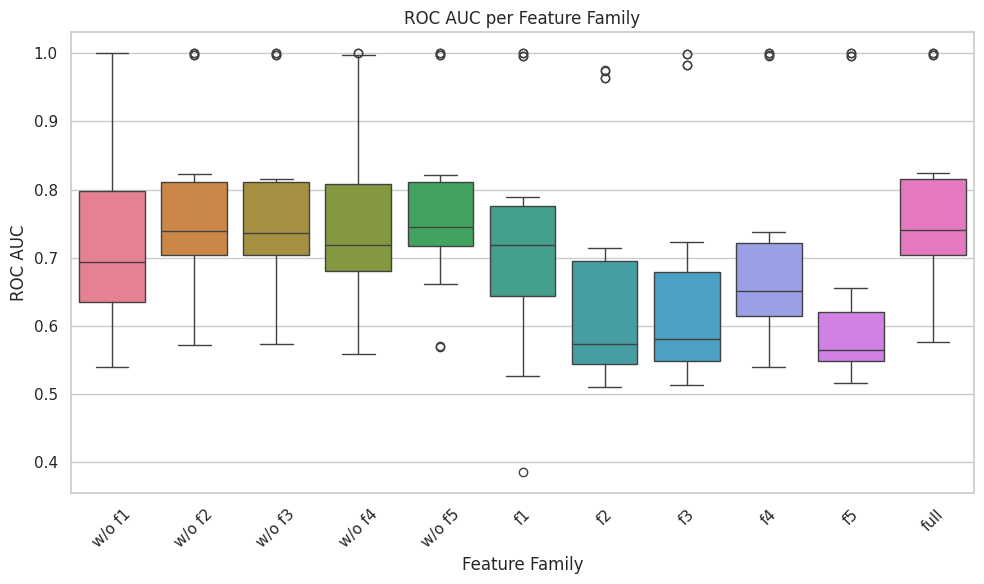

In [ ]:
excluding = pd.concat(roc_auc_per_family_excluded.values(),axis=1)
excluding.columns = ['w/o f1', 'w/o f2', 'w/o f3', 'w/o f4', 'w/o f5']
including = pd.concat(roc_auc_per_family_included.values(),axis=1)
including.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
full.columns = ['full']
merged = pd.concat([excluding, including, full], axis=1)
#seaborn boxplot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=merged)
plt.xticks(rotation=45)
plt.ylabel('ROC AUC')
plt.xlabel('Feature Family')
plt.title('ROC AUC per Feature Family')
plt.tight_layout()
plt.show()

In [ ]:
# random forest feature importance 
import numpy as np
from sklearn.ensemble import RandomForestClassifier

X = df[df.columns[8:]]
y = df['is_causal']

rf = RandomForestClassifier(n_estimators=2*35, random_state=42, n_jobs=35)
rf.fit(X, y)



ModuleNotFoundError: No module named 'seaborn'

In [ ]:
!pip install seaborn

     |████████████████████████████████| 294 kB 5.3 MB/s eta 0:00:01


In [ ]:
#plot 
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
columns = X.columns
columns = columns[indices]
importances = importances[indices]


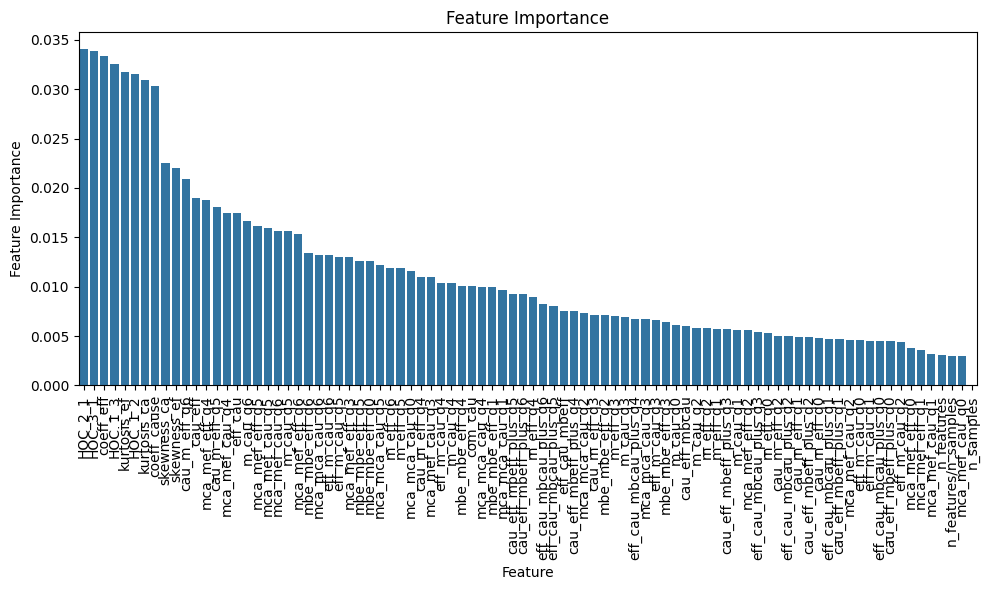

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=columns, y=importances)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.title('Feature Importance'  )
plt.tight_layout()
plt.show()

In [ ]:
#mutual information with output feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import numpy as np

X = df[df.columns[8:]]
y = df['is_causal']

selector = SelectKBest(mutual_info_classif, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
columns = X.columns
columns = columns[selector.get_support()]


In [ ]:

subset = ['HOC_1_3',
       'HOC_3_1', 
          'cau_m_eff_q5',
       'eff_m_cau_q5', 
       'mca_mef_cau_q5', 
           'mca_mef_eff_q5']


In [ ]:
X_full = df[df.columns[8:]]
y_full = df['is_causal']
groups = df['process_id']

logo = LeaveOneGroupOut()
logo.get_n_splits(X_full, y_full, groups)

df_scores = pd.DataFrame(columns=['roc_auc'])
columns = X_full.columns
X = X_full[subset]
for train_index, test_index in tqdm(logo.split(X, y_full, groups)):
    group = groups[test_index[0]]

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=N_JOBS*2, random_state=42, n_jobs=N_JOBS)
    # brf = BalancedRandomForestClassifier(n_estimators=50, random_state=42, sampling_strategy='all',replacement=True,n_jobs=25)

    rf.fit(X_train, y_train)
    # brf.fit(X_train, y_train)

    y_hat_rf = rf.predict_proba(X_test)[:,-1]
    # y_hat_brf = brf.predict_proba(X_test)[:,-1]

    score_rf = roc_auc_score(y_test, y_hat_rf)
    # score_brf = roc_auc_score(y_test, y_hat_brf)

    df_scores.loc[group] = [score_rf]

18it [07:07, 23.75s/it]


In [ ]:
df_scores

,roc_auc
1,0.532541
2,0.600188
3,0.537098
4,0.747301
6,0.576453
7,0.565202
8,0.650123
9,1.000000
10,0.503697
11,0.687198


In [ ]:
full

,roc_auc
1,0.757620
2,0.650544
3,0.618276
4,0.794463
6,0.668440
7,0.646166
8,0.734393
9,1.000000
10,0.536852
11,0.788833


In [ ]:

#plot
import matplotlib.pyplot as plt
import seaborn as sns

support = selector.get_support()
importances = selector.scores_

plt.figure(figsize=(10, 6))
sns.barplot(x=df.columns[8:], y=importances, hue=support, dodge=False, palette='viridis', alpha=0.8, edgecolor='black', linewidth=0.5, saturation=1, errcolor='black')
plt.show()

In [ ]:
df_scores.to_csv('roc_auc_scores-LOPO-descriptors_small-M15.csv')

In [ ]:
df_scores

,rf,brf
1,0.600809,0.605893
2,0.647114,0.648916
3,0.576218,0.582319
4,0.739277,0.736478
5,0.632482,0.633446
6,0.588974,0.591467
7,0.616874,0.609705
8,0.641087,0.640617
9,0.988756,0.971046
10,0.528889,0.531796


In [ ]:
X_full = df[df.columns[8:]]
y_full = df['is_causal']

X_train = X_full.loc[df.process_id % 2 == 0]
y_train = y_full.loc[df.process_id % 2 == 0]
X_test = X_full.loc[df.process_id % 2 == 1]
y_test = y_full.loc[df.process_id % 2 == 1]

In [ ]:
X_full.shape, X_train.shape, X_test.shape

((1164988, 88), (646588, 88), (518400, 88))

In [ ]:
# Assuming `df`, `X`, and `y` are already defined:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold


In [ ]:
rf = RandomForestClassifier(n_estimators=5, random_state=42, n_jobs=5)
roc_auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)


In [ ]:

# Initialize the classifier

# Define ROC AUC scorer

# Create the RFE object and compute a cross-validated score with ROC AUC
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=StratifiedKFold(5),
    scoring=roc_auc_scorer,
    min_features_to_select=min_features_to_select
)

# Fit RFECV
rfecv.fit(X_train, y_train)

# Get the selected features based on the best cross-validation score
selected_features = [f for f, s in zip(X_train.columns, rfecv.support_) if s]

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features:', selected_features)


In [ ]:
# save roc_auc_per_family_excluded
with open('features_rfecv.pkl', 'wb') as f:
    pickle.dump((selected_features,rfecv), f)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score


In [ ]:

# Assuming `X` and `y` are already defined:
# Define ROC AUC scorer
roc_auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)

# Forward Feature Selection
sfs_forward = SequentialFeatureSelector(
    rf, 
    n_features_to_select='auto',  # Automatically select the number of features
    tol=0.005,  # Stop if the score is not improved by at least 0.005
    direction='forward',  # Forward selection
    scoring=roc_auc_scorer,
    cv=5
)

# Fit the forward selector
sfs_forward.fit(X_train, y_train)

# Selected features for forward selection
selected_features_forward = X_train.columns[sfs_forward.get_support()]


In [ ]:
# save roc_auc_per_family_excluded
with open('features_forward.pkl', 'wb') as f:
    pickle.dump(selected_features_forward, f)

In [ ]:
print(f'Selected features for forward selection: {selected_features_forward}')


In [ ]:

# Backward Feature Selection
sfs_backward = SequentialFeatureSelector(
    rf, 
    n_features_to_select='auto',  # Automatically select the number of features
    tol=-0.005,  # Stop if the score is not reduced by at least 0.005
    direction='backward',  # Backward selection
    scoring=roc_auc_scorer,
    cv=2,
    n_jobs=2
)

# Fit the backward selector
sfs_backward.fit(X_train, y_train)

# Selected features for backward selection
selected_features_backward = X_train.columns[sfs_backward.get_support()]

# Output the results
print(f'Selected features for backward selection: {selected_features_backward}')


Selected features for backward selection: Index(['com_cau', 'coeff_cause', 'coeff_eff', 'cau_eff', 'eff_cau',
       'eff_cau_mbeff', 'cau_eff_mbcau', 'eff_cau_mbcau_plus_q1',
       'eff_cau_mbcau_plus_q2', 'eff_cau_mbcau_plus_q3',
       'eff_cau_mbcau_plus_q4', 'eff_cau_mbcau_plus_q5',
       'eff_cau_mbcau_plus_q6', 'cau_eff_mbeff_plus_q0',
       'cau_eff_mbeff_plus_q1', 'cau_eff_mbeff_plus_q5',
       'cau_eff_mbeff_plus_q6', 'm_cau_q0', 'm_cau_q1', 'm_cau_q2', 'm_cau_q5',
       'm_cau_q6', 'm_eff_q0', 'm_eff_q2', 'm_eff_q3', 'm_eff_q4',
       'cau_m_eff_q1', 'cau_m_eff_q2', 'cau_m_eff_q4', 'cau_m_eff_q5',
       'cau_m_eff_q6', 'eff_m_cau_q3', 'eff_m_cau_q4', 'eff_m_cau_q6',
       'mca_mef_cau_q0', 'mca_mef_cau_q1', 'mca_mef_cau_q2', 'mca_mef_cau_q3',
       'mca_mef_cau_q4', 'mca_mef_cau_q5', 'mca_mef_eff_q0', 'mca_mef_eff_q1',
       'mca_mef_eff_q2', 'mca_mef_eff_q3', 'mca_mef_eff_q4', 'mca_mef_eff_q5',
       'mca_mef_eff_q6', 'mca_mca_cau_q0', 'mca_mca_cau_q1', 'mca_mca_

In [ ]:
# save roc_auc_per_family_excluded
with open('features_backward.pkl', 'wb') as f:
    pickle.dump(selected_features_backward, f)